## Descripción de las Variables de Entrada

- `Loan_ID`: Identificador único para cada solicitud de préstamo.
- `Gender`: Género del solicitante (Masculino/Femenino).
- `Married`: Estado civil del solicitante (Sí/No).
- `Dependents`: Número de dependientes que tiene el solicitante.
- `Education`: Nivel educativo del solicitante (Graduado/No Graduado).
- `Self_Employed`: Indica si el solicitante es trabajador por cuenta propia (Sí/No).
- `ApplicantIncome`: Ingreso del solicitante del préstamo.
- `CoapplicantIncome`: Ingreso del co-solicitante del préstamo.
- `LoanAmount`: Monto del préstamo solicitado.
- `Loan_Amount_Term`: Plazo del préstamo en meses.
- `Credit_History`: Historial crediticio del solicitante (1 si tiene historial crediticio, 0 en caso contrario).
- `Property_Area`: Zona de la propiedad (Urbana/Rural/Semiurbana).
- `Loan_Status`: Estado de la solicitud de préstamo (Aprobado/Negado).

## Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score, roc_curve, precision_score, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


## Análisis exploratorio

In [2]:
data = pd.read_csv("archive/train_u6lujuX_CVtuZ9i.csv")

In [3]:
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Buscamos valores nulos y su ubicación

In [6]:
# Identificar valores faltantes en cada columna
missing_values = data.isnull().sum()

# Mostrar las columnas con valores faltantes y su cantidad
missing_values[missing_values > 0]


Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

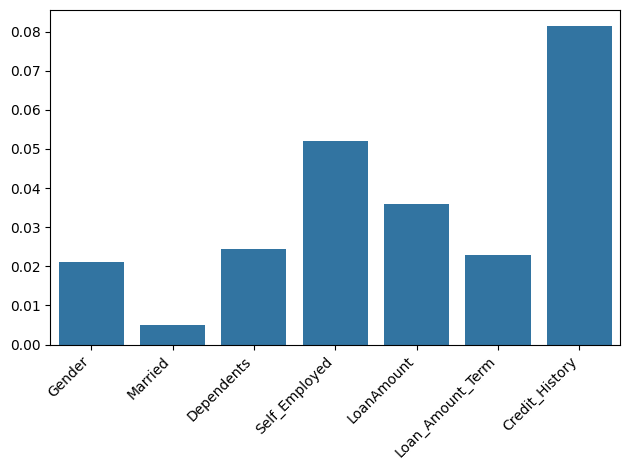

In [7]:
sns.barplot(data.drop(data.dropna(axis=1).columns, axis=1).isna().mean())

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()


### Calculamos el porcentaje de valores faltantes por si es viable eliminarlos

In [8]:
total_cells = np.product(data.shape)
total_missing = data.isnull().sum().sum()

percentage_missing = (total_missing / total_cells) * 100
percentage_missing


1.8667000751691305

### Cambiamos las columnas categoricas por True o False (Numéricas)

In [9]:
data_encoded = pd.get_dummies(data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

data_encoded.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,NaN,360.0,1.0,Y,True,False,False,False,False,False,False,False,True
1,LP001003,4583,1508.0,128.0,360.0,1.0,N,True,True,True,False,False,False,False,False,False
2,LP001005,3000,0.0,66.0,360.0,1.0,Y,True,True,False,False,False,False,True,False,True
3,LP001006,2583,2358.0,120.0,360.0,1.0,Y,True,True,False,False,False,True,False,False,True
4,LP001008,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,False,False,False,True


### Rellenamos los valores nulos con `IterativeImputer` y `RandomForest`

In [10]:
# Asegúrate de que 'data_encoded' tiene todas las columnas necesarias y está correctamente preparado
train_data_for_imputation = data_encoded.drop(['Loan_ID', 'Loan_Status'], axis=1)

# Inicializa el IterativeImputer
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=0), tol=1e-3, max_iter=20, verbose=2)

# Selecciona todas las columnas para imputación, ya que 'data_encoded' debería contener solo las relevantes después de drop
data_imputed = imputer.fit_transform(train_data_for_imputation)

# Asegúrate de convertir el array imputado de nuevo a un DataFrame y preserva los nombres de las columnas
data_imputed_df = pd.DataFrame(data_imputed, columns=train_data_for_imputation.columns, index=train_data_for_imputation.index)

# Si necesitas actualizar 'data_encoded' con los nuevos valores imputados, considera reemplazar las columnas relevantes
data_encoded.update(data_imputed_df)

[IterativeImputer] Completing matrix with shape (614, 14)


[IterativeImputer] Ending imputation round 1/20, elapsed time 4.50
[IterativeImputer] Change: 341.3478378378378, scaled tolerance: 81.0 
[IterativeImputer] Ending imputation round 2/20, elapsed time 9.03
[IterativeImputer] Change: 21.0, scaled tolerance: 81.0 
[IterativeImputer] Early stopping criterion reached.


In [11]:
# Revisar si aún hay valores faltantes en las columnas imputadas
data_encoded.isnull().sum()


Loan_ID                    0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Loan_Status                0
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64

In [12]:
print("Antes de la imputación:")
print(data_encoded['Credit_History'].describe())

print("\nDespués de la imputación:")
print(data_encoded['Credit_History'].describe())


Antes de la imputación:
count    614.000000
mean       0.840684
std        0.351703
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Credit_History, dtype: float64

Después de la imputación:
count    614.000000
mean       0.840684
std        0.351703
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Credit_History, dtype: float64


Observamos que al tratar los nulos no cambia ningún valor. Podríamos haberlos eliminado.

## Ingeniería de características.

### Creación de columnas nuevas en función de los datos para intentar dar mas valor.

In [13]:
# Ingeniería de características: Creación de nuevas características
data_encoded['TotalIncome'] = data_encoded['ApplicantIncome'] + data_encoded['CoapplicantIncome']
data_encoded['LoanIncomeRatio'] = data_encoded['LoanAmount'] / data_encoded['TotalIncome']

# Creación de una característica de interacción entre TotalIncome y LoanAmount
data_encoded['IncomeLoanInteraction'] = data_encoded['TotalIncome'] * data_encoded['LoanAmount']

# Creación de características polinomiales para LoanAmount (al cuadrado y al cubo)
data_encoded['LoanAmount_squared'] = data_encoded['LoanAmount'] ** 2
data_encoded['LoanAmount_cubed'] = data_encoded['LoanAmount'] ** 3

# Seleccionar características numéricas para normalización (excluyendo las que ya están en escala binaria)
features_to_normalize = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanIncomeRatio']

scaler = MinMaxScaler()
data_encoded[features_to_normalize] = scaler.fit_transform(data_encoded[features_to_normalize])

# Mostrar las primeras filas para revisar los cambios realizados
data_encoded.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,...,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,LoanIncomeRatio,IncomeLoanInteraction,LoanAmount_squared,LoanAmount_cubed
0,LP001002,0.070489,0.000000,0.196614,0.74359,1.0,Y,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.055394,0.277392,847286.14,20984.4196,3.039803e+06
1,LP001003,0.054830,0.036192,0.172214,0.74359,1.0,N,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.058435,0.230602,779648.00,16384.0000,2.097152e+06
2,LP001005,0.035250,0.000000,0.082489,0.74359,1.0,Y,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.019583,0.242891,198000.00,4356.0000,2.874960e+05
3,LP001006,0.030093,0.056592,0.160637,0.74359,1.0,Y,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.043980,0.271406,592920.00,14400.0000,1.728000e+06
4,LP001008,0.072356,0.000000,0.191027,0.74359,1.0,Y,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.057292,0.261596,846000.00,19881.0000,2.803221e+06


## Gráficas

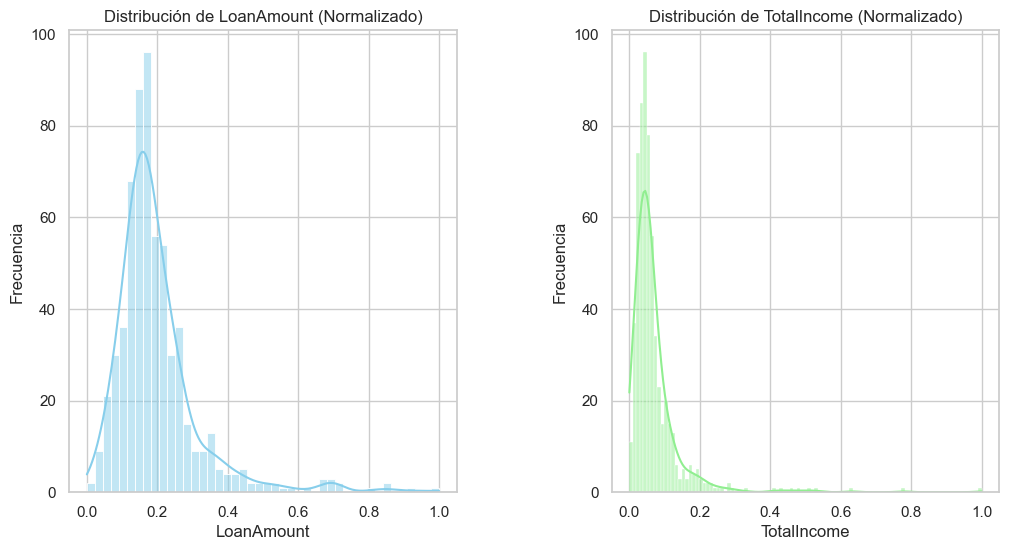

In [14]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_encoded['LoanAmount'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribución de LoanAmount (Normalizado)')
ax[0].set_xlabel('LoanAmount')
ax[0].set_ylabel('Frecuencia')

sns.histplot(data_encoded['TotalIncome'], kde=True, ax=ax[1], color='lightgreen')
ax[1].set_title('Distribución de TotalIncome (Normalizado)')
ax[1].set_xlabel('TotalIncome')
ax[1].set_ylabel('Frecuencia')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


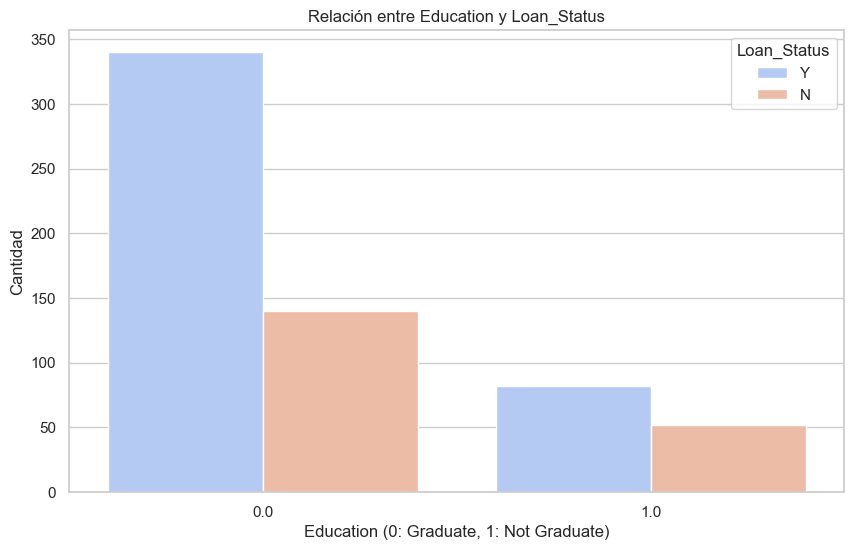

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(x='Education_Not Graduate', hue='Loan_Status', data=data_encoded, ax=ax, palette='coolwarm')
ax.set_title('Relación entre Education y Loan_Status')
ax.set_xlabel('Education (0: Graduate, 1: Not Graduate)')
ax.set_ylabel('Cantidad')
ax.legend(title='Loan_Status')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


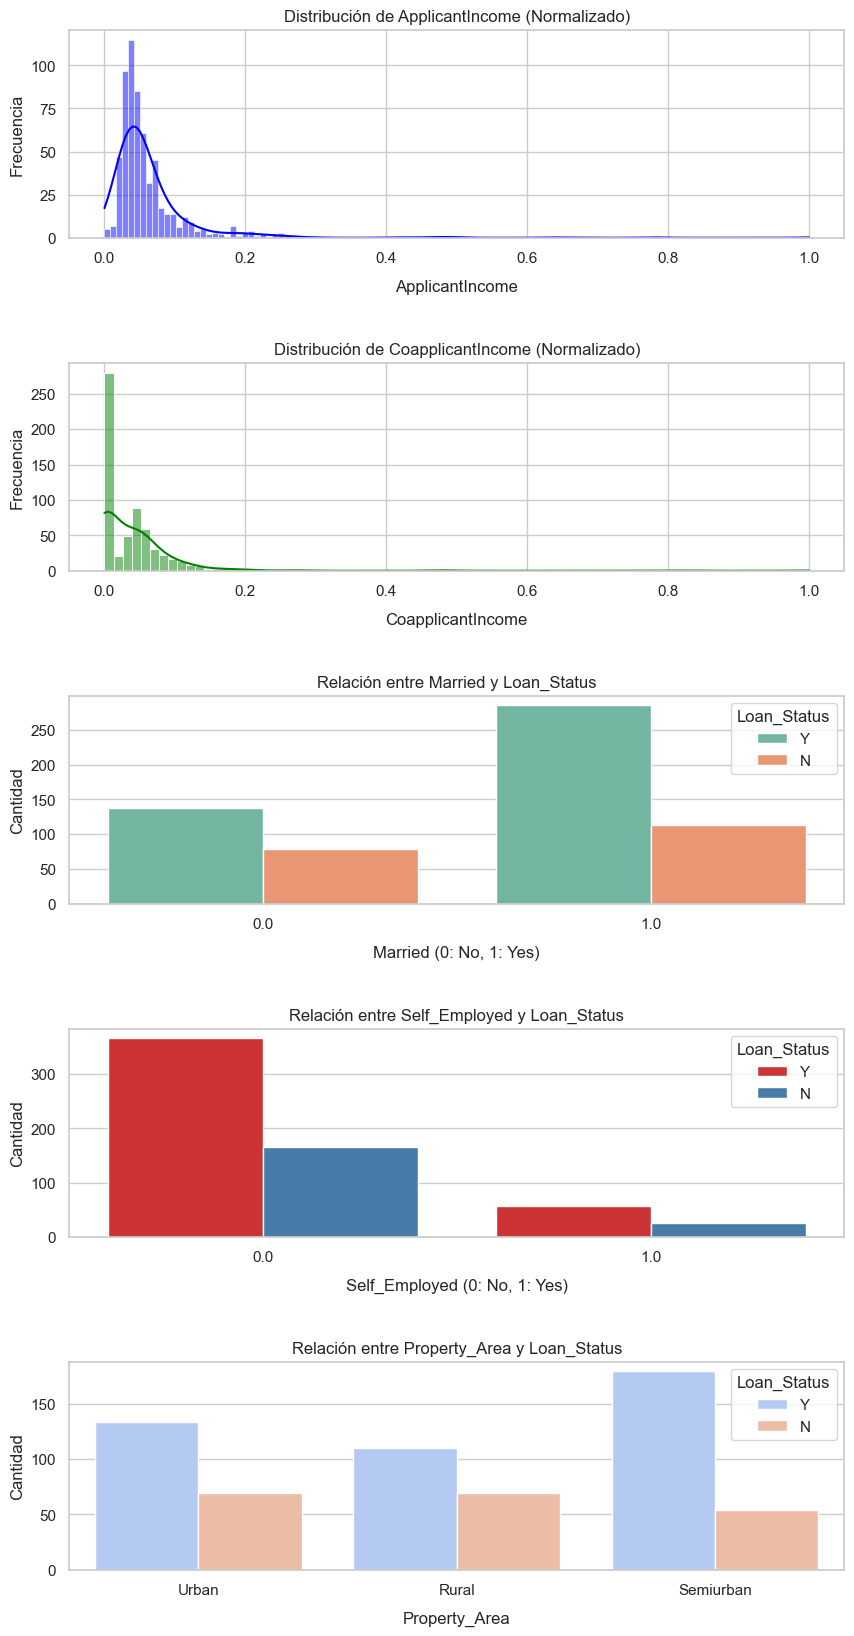

In [16]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))

# 1. Distribución de ApplicantIncome
sns.histplot(data_encoded['ApplicantIncome'], kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribución de ApplicantIncome (Normalizado)')
ax[0].set_xlabel('ApplicantIncome', labelpad=10)
ax[0].set_ylabel('Frecuencia')

# 2. Distribución de CoapplicantIncome
sns.histplot(data_encoded['CoapplicantIncome'], kde=True, ax=ax[1], color='green')
ax[1].set_title('Distribución de CoapplicantIncome (Normalizado)')
ax[1].set_xlabel('CoapplicantIncome', labelpad=10)
ax[1].set_ylabel('Frecuencia')

# 3. Relación entre Married y Loan_Status
sns.countplot(x='Married_Yes', hue='Loan_Status', data=data_encoded, ax=ax[2], palette='Set2')
ax[2].set_title('Relación entre Married y Loan_Status')
ax[2].set_xlabel('Married (0: No, 1: Yes)', labelpad=10)
ax[2].set_ylabel('Cantidad')
ax[2].legend(title='Loan_Status')

# 4. Relación entre Self_Employed y Loan_Status
sns.countplot(x='Self_Employed_Yes', hue='Loan_Status', data=data_encoded, ax=ax[3], palette='Set1')
ax[3].set_title('Relación entre Self_Employed y Loan_Status')
ax[3].set_xlabel('Self_Employed (0: No, 1: Yes)', labelpad=10)
ax[3].set_ylabel('Cantidad')
ax[3].legend(title='Loan_Status')

# 5. Relación entre Property_Area y Loan_Status
sns.countplot(x=data['Property_Area'], hue='Loan_Status', data=data, ax=ax[4], palette='coolwarm')
ax[4].set_title('Relación entre Property_Area y Loan_Status')
ax[4].set_xlabel('Property_Area', labelpad=10)
ax[4].set_ylabel('Cantidad')
ax[4].legend(title='Loan_Status')

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

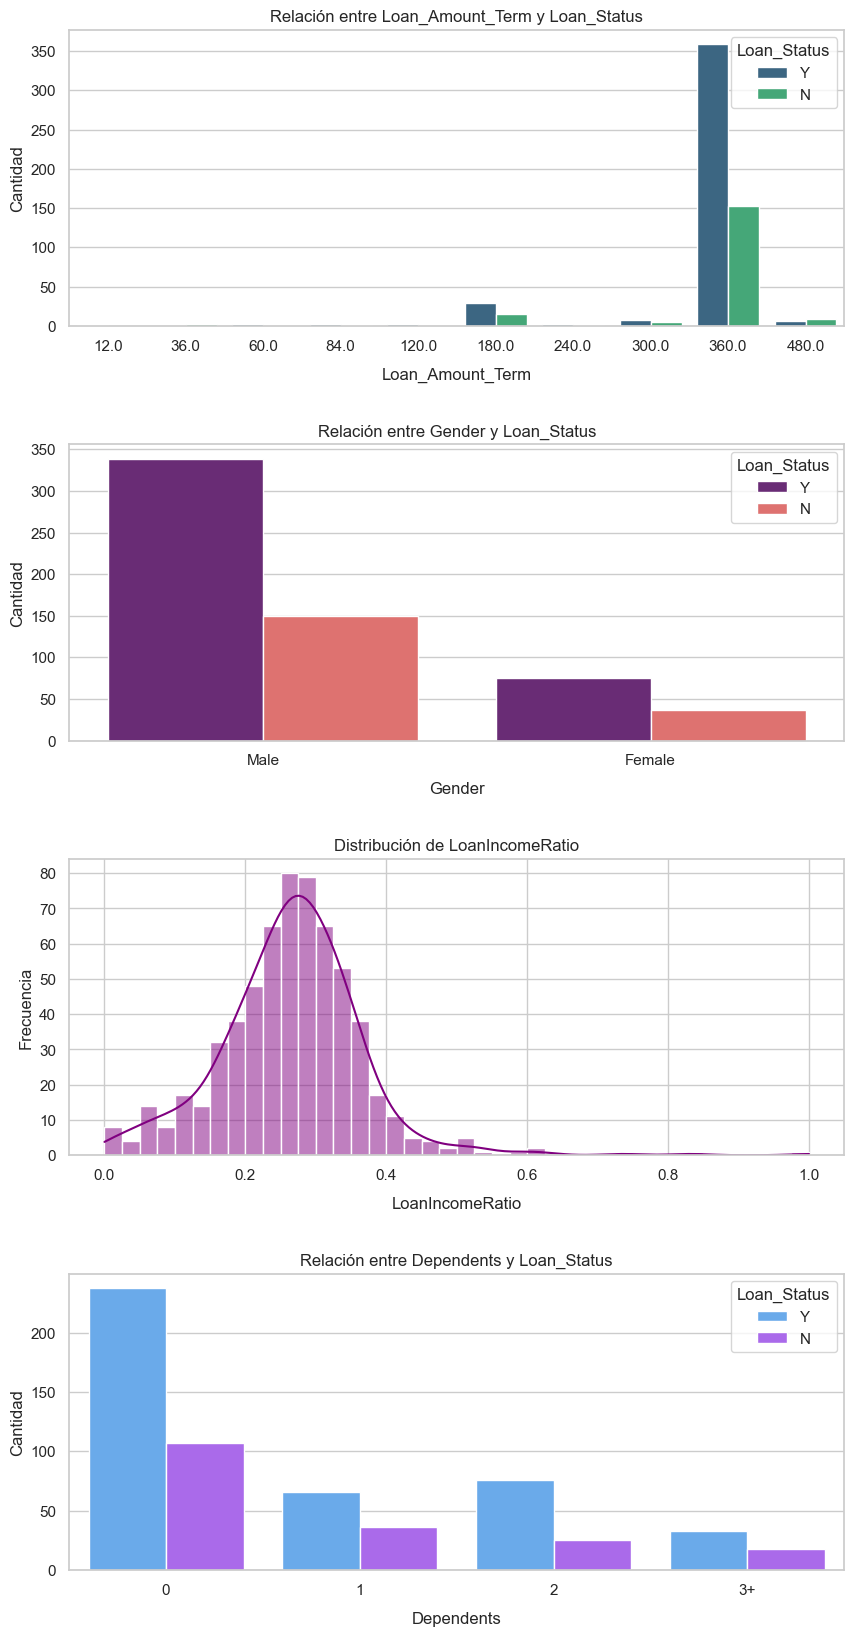

In [17]:
fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# 6. Relación entre Loan_Amount_Term y Loan_Status
sns.countplot(x='Loan_Amount_Term', hue='Loan_Status', data=data, ax=ax[0], palette='viridis')
ax[0].set_title('Relación entre Loan_Amount_Term y Loan_Status')
ax[0].set_xlabel('Loan_Amount_Term', labelpad=10)
ax[0].set_ylabel('Cantidad')
ax[0].legend(title='Loan_Status')

# 7. Relación entre Gender y Loan_Status
sns.countplot(x=data['Gender'], hue='Loan_Status', data=data, ax=ax[1], palette='magma')
ax[1].set_title('Relación entre Gender y Loan_Status')
ax[1].set_xlabel('Gender', labelpad=10)
ax[1].set_ylabel('Cantidad')
ax[1].legend(title='Loan_Status')

# 8. Distribución de LoanIncomeRatio
sns.histplot(data_encoded['LoanIncomeRatio'], kde=True, ax=ax[2], color='purple')
ax[2].set_title('Distribución de LoanIncomeRatio')
ax[2].set_xlabel('LoanIncomeRatio', labelpad=10)
ax[2].set_ylabel('Frecuencia')

# 9. Relación entre el número de dependientes (Dependents) y Loan_Status
sns.countplot(x='Dependents', hue='Loan_Status', data=data, ax=ax[3], palette='cool')
ax[3].set_title('Relación entre Dependents y Loan_Status')
ax[3].set_xlabel('Dependents', labelpad=10)
ax[3].set_ylabel('Cantidad')
ax[3].legend(title='Loan_Status')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [18]:
data.columns


Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [19]:
data_encoded.columns

Index(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Male',
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome',
       'LoanIncomeRatio', 'IncomeLoanInteraction', 'LoanAmount_squared',
       'LoanAmount_cubed'],
      dtype='object')

Generamos un pairplot para visualizar alguna tendencia o característica clave.

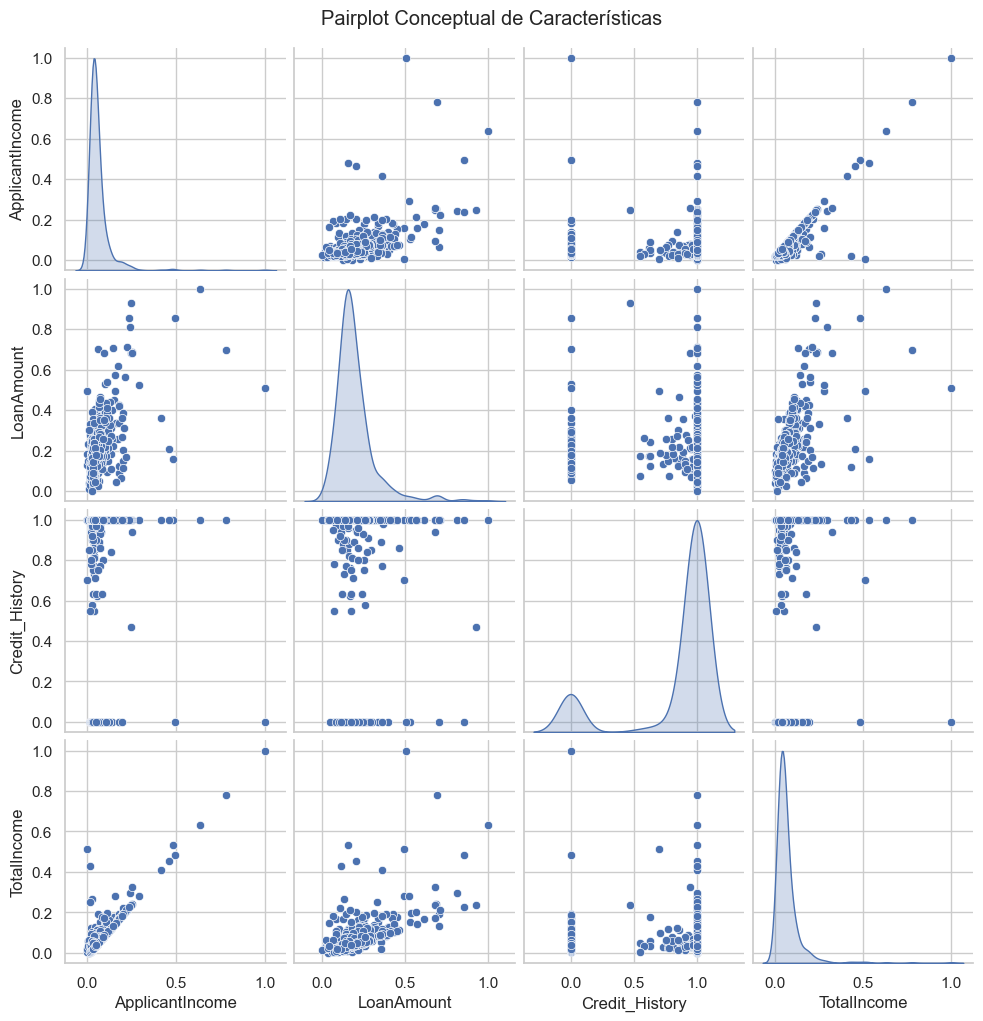

In [20]:
features_subset_conceptual = ['ApplicantIncome', 'LoanAmount', 'Credit_History', 'TotalIncome']

# Generar pairplot para el subconjunto conceptual de características
sns.pairplot(data_encoded[features_subset_conceptual], diag_kind='kde')
plt.suptitle('Pairplot Conceptual de Características', y=1.02)  
plt.show()


### Mapa de correlación entre columnas

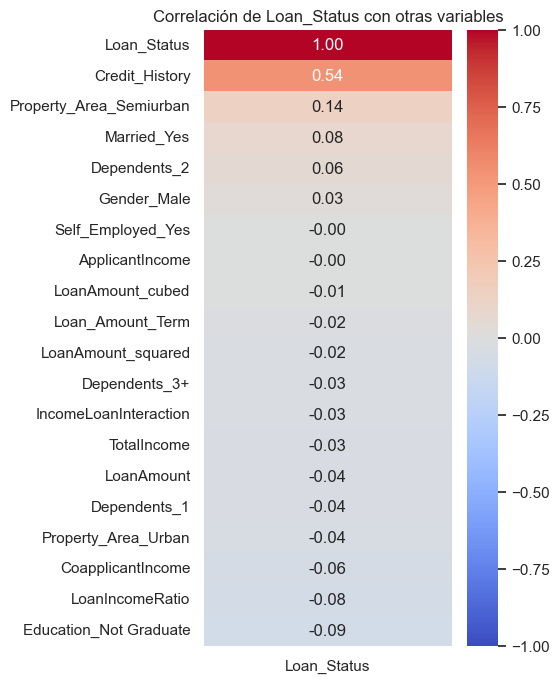

In [21]:
data_for_corr = data_encoded.copy()

if data_for_corr['Loan_Status'].dtype == 'object':
    le = LabelEncoder()
    data_for_corr['Loan_Status'] = le.fit_transform(data_for_corr['Loan_Status'])

data_for_corr = data_for_corr.drop(['Loan_ID'], axis=1)

corr_matrix = data_for_corr.corr()

loan_status_corr = corr_matrix[['Loan_Status']].sort_values(by='Loan_Status', ascending=False)

plt.figure(figsize=(4, 8))
sns.heatmap(loan_status_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlación de Loan_Status con otras variables')
plt.show()


## Conclusiones tras análisis

Historial Crediticio y Aprobación de Préstamos:

Los solicitantes con un historial crediticio positivo (1.0) tienen una tasa de aprobación de préstamos significativamente más alta (aproximadamente el 79.58%) en comparación con aquellos con un historial crediticio negativo (0.0), donde solo aproximadamente el 7.87% logra la aprobación.
Educación y Aprobación de Préstamos:

Los solicitantes graduados tienen una mayor tasa de aprobación de préstamos (aproximadamente el 70.83%) en comparación con los no graduados (aproximadamente el 61.19%).
Área de Propiedad y Aprobación de Préstamos:

Las solicitudes de préstamos en áreas semiurbanas tienen la mayor tasa de aprobación (aproximadamente el 76.82%), seguidas por las áreas rurales (aproximadamente el 61.45%) y urbanas (aproximadamente el 65.84%).

## Machine Learning con ajustes de hiperpárametros

#### Separamos el conjunto de datos de entrenamiento y datos de prueba habiendo cambiado por 1 los valores de Loan_Status aprobados y 0, los denegados

In [22]:
y = data_encoded['Loan_Status'].map({'Y': 1, 'N': 0})  
X = data_encoded.drop(['Loan_ID', 'Loan_Status', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount_squared', 'LoanAmount_cubed'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loan_ID                  614 non-null    object 
 1   ApplicantIncome          614 non-null    float64
 2   CoapplicantIncome        614 non-null    float64
 3   LoanAmount               614 non-null    float64
 4   Loan_Amount_Term         614 non-null    float64
 5   Credit_History           614 non-null    float64
 6   Loan_Status              614 non-null    object 
 7   Gender_Male              614 non-null    float64
 8   Married_Yes              614 non-null    float64
 9   Dependents_1             614 non-null    float64
 10  Dependents_2             614 non-null    float64
 11  Dependents_3+            614 non-null    float64
 12  Education_Not Graduate   614 non-null    float64
 13  Self_Employed_Yes        614 non-null    float64
 14  Property_Area_Semiurban  6

#### Probamos 4 modelos básicos para ver como van funcionando

In [24]:
# Inicializar los modelos
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier()
}

# Entrenar los modelos y evaluar su precisión
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {accuracy}")


LogisticRegression accuracy: 0.6504065040650406
SVM accuracy: 0.6504065040650406
KNN accuracy: 0.5853658536585366
DecisionTree accuracy: 0.7642276422764228


### Empezamos con el módelo Random Forest y vemos que en accuracy se va desmarcando.

In [25]:
# Inicializar y entrenar el modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"La precisión del modelo es: {accuracy}")


La precisión del modelo es: 0.8211382113821138


In [26]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=1000, cv=5, scoring='accuracy', 
                                      random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

print("Mejores parámetros:", random_search_rf.best_params_)
print("Mejor precisión:", random_search_rf.best_score_)

best_rf_model = random_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
print(f"Random Forest (con mejores parámetros) precisión: {accuracy_score(y_test, y_pred_best_rf)}")


Mejores parámetros: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 196}
Mejor precisión: 0.8206349206349206
Random Forest (con mejores parámetros) precisión: 0.8130081300813008


In [27]:
precision = precision_score(y_test, y_pred_best_rf)
recall = recall_score(y_test, y_pred_best_rf)
f1 = f1_score(y_test, y_pred_best_rf)
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Precision: 0.7938144329896907
Recall: 0.9625
F1 Score: 0.8700564971751412
ROC AUC Score: 0.7325581395348837


<module 'matplotlib.pyplot' from 'C:\\Users\\memol\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

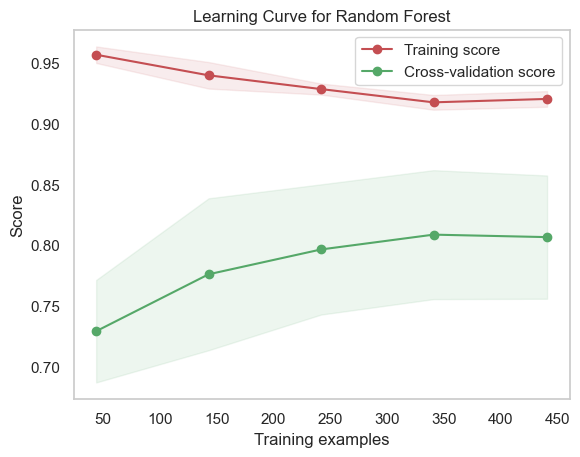

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Ahora, genera la curva de aprendizaje para el modelo de Random Forest
plot_learning_curve(estimator=best_rf_model, title="Learning Curve for Random Forest", X=X_train, y=y_train, cv=10, n_jobs=-1)


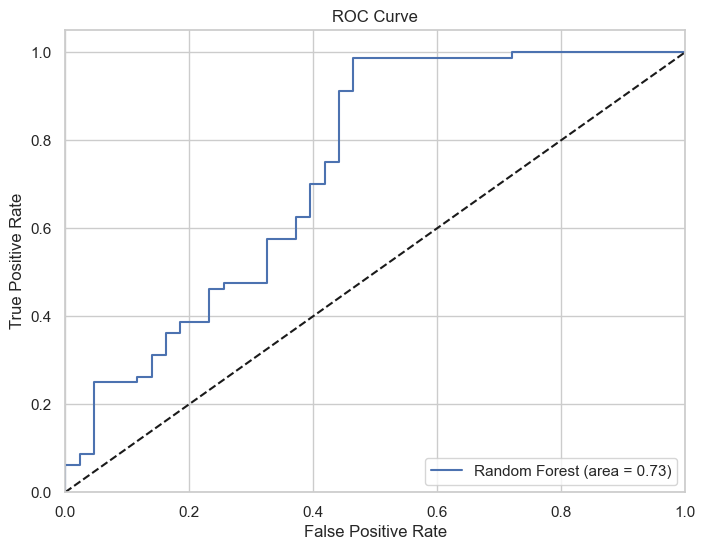

In [29]:
# Calcula las tasas de verdaderos y falsos positivos y el área bajo la curva (AUC) para RF
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Graficar la curva ROC para RF
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')

# Configuraciones adicionales del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### XGBoost

In [30]:
# Inicializar y entrenar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost accuracy: {accuracy_xgb}")


XGBoost accuracy: 0.7642276422764228


In [31]:
param_distributions = {
    'n_estimators': randint(100, 500),  
    'learning_rate': uniform(0.01, 0.5),  
    'max_depth': randint(3, 10),  
    'subsample': uniform(0.5, 0.5),  
    'colsample_bytree': uniform(0.5, 0.5)  
}

# Crear RandomizedSearchCV para XGBoost
random_search_xgb = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                                    param_distributions=param_distributions, n_iter=1000, cv=10, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

print("XGBoost - Mejores parámetros:", random_search_xgb.best_params_)
print("XGBoost - Mejor precisión:", random_search_xgb.best_score_)

# Entrenar de nuevo usando los mejores parámetros
best_xgb_model = XGBClassifier(**random_search_xgb.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)
y_pred_best_xgb = best_xgb_model.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"XGBoost (con mejores parámetros) precisión: {accuracy_best_xgb}")


XGBoost - Mejores parámetros: {'colsample_bytree': 0.6837672111457658, 'learning_rate': 0.044086154692746786, 'max_depth': 4, 'n_estimators': 124, 'subsample': 0.61627567918269}
XGBoost - Mejor precisión: 0.8228163265306122
XGBoost (con mejores parámetros) precisión: 0.7967479674796748


In [32]:
precision = precision_score(y_test, y_pred_best_xgb)
recall = recall_score(y_test, y_pred_best_xgb)
f1 = f1_score(y_test, y_pred_best_xgb)
roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Precision: 0.7894736842105263
Recall: 0.9375
F1 Score: 0.8571428571428572
ROC AUC Score: 0.7651162790697674


In [33]:
# Usamos el mejor modelo encontrado por RandomizedSearchCV
best_model = random_search_xgb.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.7967479674796748


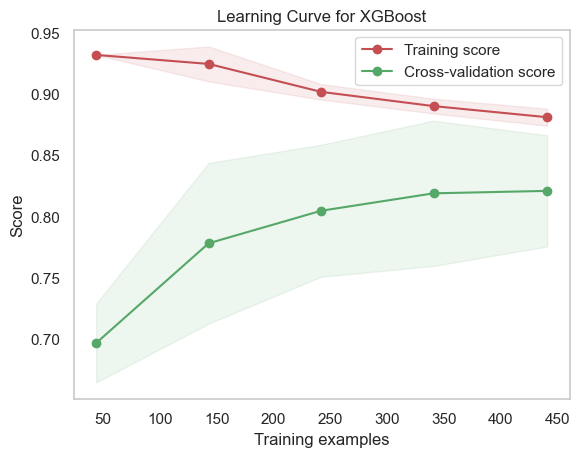

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(estimator=best_xgb_model, title="Learning Curve for XGBoost", X=X_train, y=y_train, cv=10, n_jobs=-1)
plt.show()


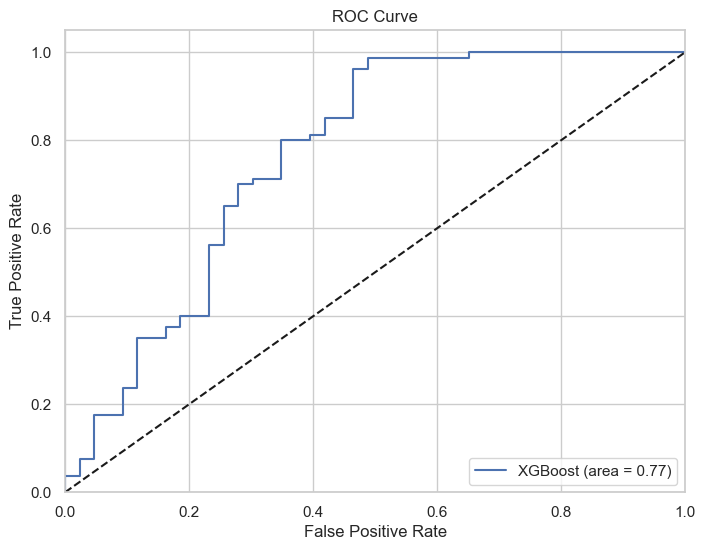

In [35]:
# Calcula las tasas de verdaderos y falsos positivos y el área bajo la curva (AUC) para XGBosost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, best_xgb_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Graficar la curva ROC para RF
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')

# Configuraciones adicionales del gráfico
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### Gradient Boosting

In [36]:
gb_model = GradientBoostingClassifier(random_state=42)

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting accuracy: {accuracy_gb}")


Gradient Boosting accuracy: 0.7886178861788617


In [37]:
# Definimos el espacio de parámetros para RandomizedSearchCV
param_distributions_gb = {
    'n_estimators': randint(100, 500),
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions_gb,
    n_iter=1000,
    cv=10,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search_gb.fit(X_train, y_train)

# Mostrar los mejores parámetros y la mejor precisión
print("Mejores parámetros para Gradient Boosting:", random_search_gb.best_params_)
print("Mejor precisión con Gradient Boosting:", random_search_gb.best_score_)

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_gb_model = random_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
print(f"Gradient Boosting (con mejores parámetros) precisión: {accuracy_best_gb}")


Mejores parámetros para Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 325}
Mejor precisión con Gradient Boosting: 0.8167346938775509
Gradient Boosting (con mejores parámetros) precisión: 0.7804878048780488


In [38]:
precision = precision_score(y_test, y_pred_best_gb)
recall = recall_score(y_test, y_pred_best_gb)
f1 = f1_score(y_test, y_pred_best_gb)
roc_auc = roc_auc_score(y_test, best_gb_model.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Precision: 0.7849462365591398
Recall: 0.9125
F1 Score: 0.8439306358381503
ROC AUC Score: 0.7315406976744186


<module 'matplotlib.pyplot' from 'C:\\Users\\memol\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

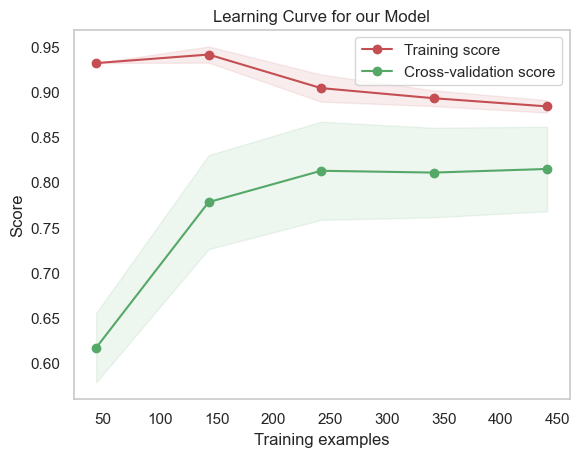

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Ejemplo de uso:
plot_learning_curve(estimator=best_gb_model, title="Learning Curve for our Model", X=X_train, y=y_train, cv=10)


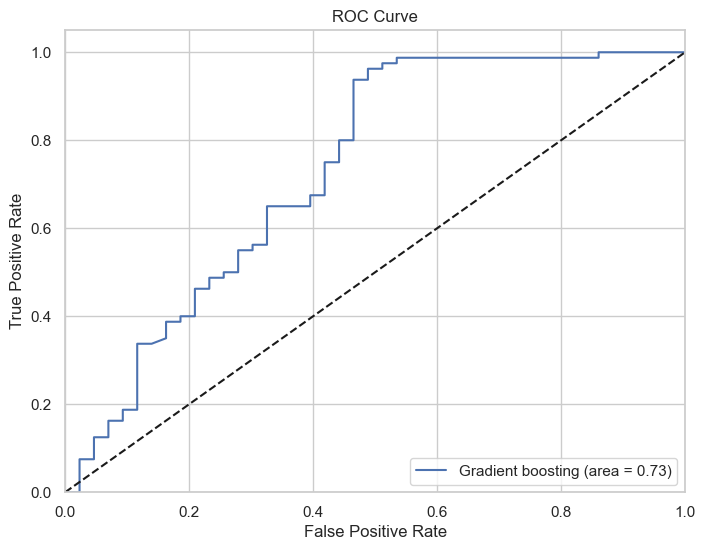

In [40]:
# Calcula las tasas de verdaderos y falsos positivos y el área bajo la curva (AUC) para GB
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, best_gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Graficar la curva ROC para GB
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient boosting (area = {roc_auc_gb:.2f})')

# Configuraciones adicionales del gráfico
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### Unificamos las gráficas de ROC-AUC para ver que modelo va mejor

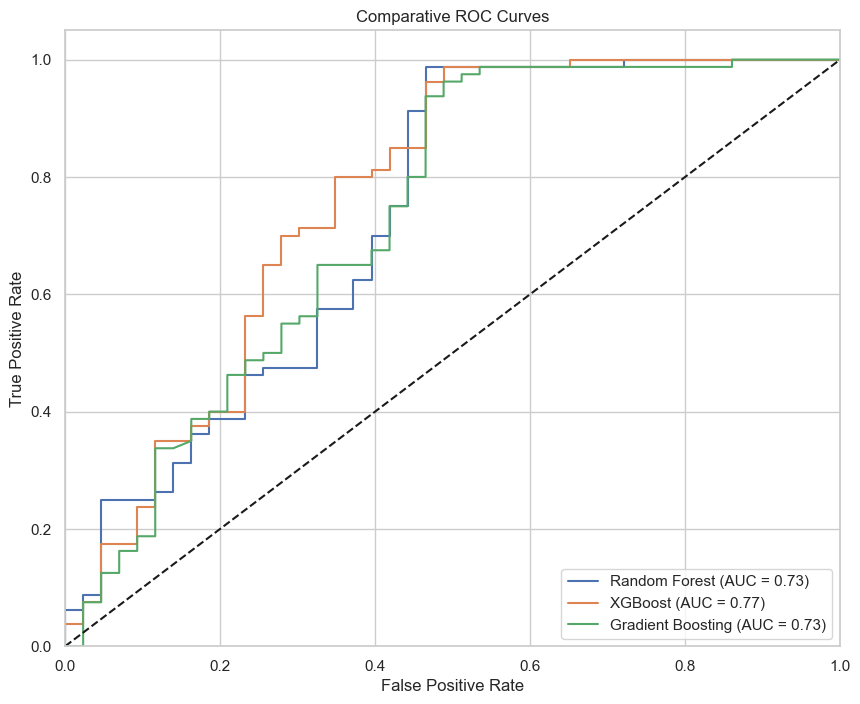

In [41]:
# Calcular las tasas de verdaderos y falsos positivos y el área bajo la curva (AUC) para cada modelo
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gb, tpr_gb, _ = roc_curve(y_test, best_gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Graficar la curva ROC para cada modelo en el mismo gráfico
plt.figure(figsize=(10, 8))

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves')
plt.legend(loc="lower right")
plt.show()


Vemos que modelo va mejor

In [42]:
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'AUC': [roc_auc_rf, roc_auc_xgb, roc_auc_gb]
})

metrics_df

,Model,AUC
0,Random Forest,0.732558
1,XGBoost,0.765116
2,Gradient Boosting,0.731541


### SMOTE. Tratamos de ver si el desbalanceo de clases (Hay mas préstamos concedidos que rechazados) influye en los modelos

In [43]:
# Asumiendo que X e y ya están definidos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [44]:
# Entrenar RF con datos balanceados por SMOTE
model_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_smote.fit(X_train_smote, y_train_smote)

# Evaluación de RF
y_pred_rf_smote = model_rf_smote.predict(X_test)

# Métricas para RF
precision_rf_smote = precision_score(y_test, y_pred_rf_smote)
recall_rf_smote = recall_score(y_test, y_pred_rf_smote)
f1_rf_smote = f1_score(y_test, y_pred_rf_smote)
roc_auc_rf_smote = roc_auc_score(y_test, model_rf_smote.predict_proba(X_test)[:, 1])

print(f"Random Forest con SMOTE - Precisión: {precision_rf_smote}, Recall: {recall_rf_smote}, F1: {f1_rf_smote}, ROC AUC: {roc_auc_rf_smote}")

Random Forest con SMOTE - Precisión: 0.7684210526315789, Recall: 0.9125, F1: 0.8342857142857143, ROC AUC: 0.7388081395348837


In [45]:
# Entrenar XGB con datos balanceados por SMOTE
model_xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_smote.fit(X_train_smote, y_train_smote)

# Evaluación de XGB
y_pred_xgb_smote = model_xgb_smote.predict(X_test)

# Métricas para RF
precision_xgb_smote = precision_score(y_test, y_pred_xgb_smote)
recall_xgb_smote = recall_score(y_test, y_pred_xgb_smote)
f1_xgb_smote = f1_score(y_test, y_pred_xgb_smote)
roc_auc_xgb_smote = roc_auc_score(y_test, model_xgb_smote.predict_proba(X_test)[:, 1])

print(f"XGBoost con SMOTE - Precisión: {precision_xgb_smote}, Recall: {recall_xgb_smote}, F1: {f1_xgb_smote}, ROC AUC: {roc_auc_xgb_smote}")


XGBoost con SMOTE - Precisión: 0.7840909090909091, Recall: 0.8625, F1: 0.8214285714285715, ROC AUC: 0.7199127906976744


In [46]:
# Entrenar GB con datos balanceados por SMOTE
model_gb_smote = GradientBoostingClassifier(random_state=42)
model_gb_smote.fit(X_train_smote, y_train_smote)

# Evaluación de GB
y_pred_gb_smote = model_gb_smote.predict(X_test)

# Métricas para RF
precision_gb_smote = precision_score(y_test, y_pred_gb_smote)
recall_gb_smote = recall_score(y_test, y_pred_gb_smote)
f1_gb_smote = f1_score(y_test, y_pred_gb_smote)
roc_auc_gb_smote = roc_auc_score(y_test, model_gb_smote.predict_proba(X_test)[:, 1])

print(f"Gradient Boosting con SMOTE - Precisión: {precision_gb_smote}, Recall: {recall_gb_smote}, F1: {f1_gb_smote}, ROC AUC: {roc_auc_gb_smote}")


Gradient Boosting con SMOTE - Precisión: 0.7894736842105263, Recall: 0.9375, F1: 0.8571428571428572, ROC AUC: 0.7428779069767442


In [47]:
def print_metrics(y_true, y_pred, y_pred_proba):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba)}")


In [48]:
# Usar los mejores hiperparámetros obtenidos para RF
best_rf_model = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)
best_rf_model.fit(X_train_smote, y_train_smote)

# Predecir y calcular métricas
y_pred_rf = best_rf_model.predict(X_test)
print_metrics(y_test, y_pred_rf, best_rf_model.predict_proba(X_test)[:, 1])


Accuracy: 0.7804878048780488
Precision: 0.7789473684210526
Recall: 0.925
F1 Score: 0.8457142857142858
ROC AUC Score: 0.7284883720930232


In [49]:

# Usar los mejores hiperparámetros obtenidos para XGB
best_xgb_model = XGBClassifier(**random_search_xgb.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train_smote, y_train_smote)

# Predecir y calcular métricas
y_pred_xgb = best_xgb_model.predict(X_test)
print_metrics(y_test, y_pred_xgb, best_xgb_model.predict_proba(X_test)[:, 1])


Accuracy: 0.7804878048780488
Precision: 0.7849462365591398
Recall: 0.9125
F1 Score: 0.8439306358381503
ROC AUC Score: 0.760610465116279


In [50]:
# Usar los mejores hiperparámetros obtenidos para GB
best_gb_model = GradientBoostingClassifier(**random_search_gb.best_params_, random_state=42)
best_gb_model.fit(X_train_smote, y_train_smote)

# Predecir y calcular métricas
y_pred_gb = best_gb_model.predict(X_test)
print_metrics(y_test, y_pred_gb, best_gb_model.predict_proba(X_test)[:, 1])


Accuracy: 0.7723577235772358
Precision: 0.7888888888888889
Recall: 0.8875
F1 Score: 0.8352941176470587
ROC AUC Score: 0.7462209302325582


Buscamos la curva ROC

In [51]:
# Para Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# Para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_model.predict_proba(X_test)[:, 1])
auc_xgb = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

# Para Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, best_gb_model.predict_proba(X_test)[:, 1])
auc_gb = roc_auc_score(y_test, best_gb_model.predict_proba(X_test)[:, 1])


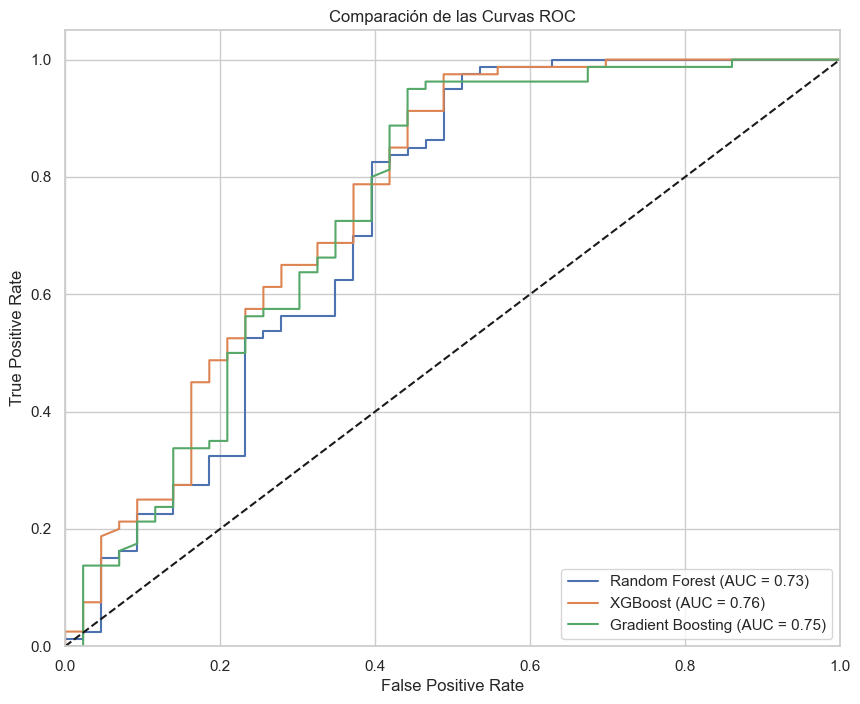

In [52]:
plt.figure(figsize=(10, 8))

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de las Curvas ROC')
plt.legend(loc="lower right")
plt.show()


In [53]:
# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'AUC': [auc_rf, auc_xgb, auc_gb]
})

metrics_df


,Model,AUC
0,Random Forest,0.728488
1,XGBoost,0.760610
2,Gradient Boosting,0.746221


Y vemos, que sin datos sintéticos el módelo XGBoost es capaz de manejar un poquito mejor los datos. apenas un 0.5%.

## Testeo

### Tratamos el dataset de testeo igual que hicimos con el de test. Todas las transformaciones igual.

In [54]:
test_file_path = 'archive/test_Y3wMUE5_7gLdaTN.csv'
test_data = pd.read_csv(test_file_path)

test_data.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [55]:
missing_values = test_data.isnull().sum()

missing_values[missing_values > 0]


Gender              11
Dependents          10
Self_Employed       23
LoanAmount           5
Loan_Amount_Term     6
Credit_History      29
dtype: int64

In [56]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for column in categorical_columns:
    test_data[column].fillna(test_data[column].mode()[0], inplace=True)

numerical_columns = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for column in numerical_columns:
    test_data[column].fillna(test_data[column].median(), inplace=True)

# Verificar si aún quedan valores faltantes
remaining_missing_values = test_data.isnull().sum().sum()

remaining_missing_values


0

In [57]:
# Codificación de variables categóricas excepto 'Loan_Status' usando pd.get_dummies
test_data_encoded = pd.get_dummies(test_data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

# Mostrar las primeras filas del DataFrame para revisar las nuevas columnas codificadas
test_data_encoded.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001015,5720,0,110.0,360.0,1.0,True,True,False,False,False,False,False,False,True
1,LP001022,3076,1500,126.0,360.0,1.0,True,True,True,False,False,False,False,False,True
2,LP001031,5000,1800,208.0,360.0,1.0,True,True,False,True,False,False,False,False,True
3,LP001035,2340,2546,100.0,360.0,1.0,True,True,False,True,False,False,False,False,True
4,LP001051,3276,0,78.0,360.0,1.0,True,False,False,False,False,True,False,False,True


In [58]:
# Ingeniería de características: Creación de nuevas características
test_data_encoded['TotalIncome'] = test_data_encoded['ApplicantIncome'] + test_data_encoded['CoapplicantIncome']
test_data_encoded['LoanIncomeRatio'] = test_data_encoded['LoanAmount'] / test_data_encoded['TotalIncome']

# Creación de una característica de interacción entre TotalIncome y LoanAmount
test_data_encoded['IncomeLoanInteraction'] = test_data_encoded['TotalIncome'] * test_data_encoded['LoanAmount']

# Creación de características polinomiales para LoanAmount (al cuadrado y al cubo)
test_data_encoded['LoanAmount_squared'] = test_data_encoded['LoanAmount'] ** 2
test_data_encoded['LoanAmount_cubed'] = test_data_encoded['LoanAmount'] ** 3

# Seleccionar características numéricas para normalización (excluyendo las que ya están en escala binaria)
features_to_normalize = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanIncomeRatio']

scaler = MinMaxScaler()
test_data_encoded[features_to_normalize] = scaler.fit_transform(test_data_encoded[features_to_normalize])

# Mostrar las primeras filas para revisar los cambios realizados
test_data_encoded.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,LoanIncomeRatio,IncomeLoanInteraction,LoanAmount_squared,LoanAmount_cubed
0,LP001015,0.078865,0.000000,0.157088,0.746835,1.0,True,True,False,False,False,False,False,False,True,0.055957,0.172625,629200.0,12100.0,1331000.0
1,LP001022,0.042411,0.062500,0.187739,0.746835,1.0,True,True,True,False,False,False,False,False,True,0.039791,0.255362,576576.0,15876.0,2000376.0
2,LP001031,0.068938,0.075000,0.344828,0.746835,1.0,True,True,False,True,False,False,False,False,True,0.071218,0.285783,1414400.0,43264.0,8998912.0
3,LP001035,0.032263,0.106083,0.137931,0.746835,1.0,True,True,False,True,False,False,False,False,True,0.044172,0.184938,488600.0,10000.0,1000000.0
4,LP001051,0.045168,0.000000,0.095785,0.746835,1.0,True,False,False,False,False,True,False,False,True,0.021422,0.218245,255528.0,6084.0,474552.0


In [59]:
test_data_encoded.columns

Index(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome',
       'LoanIncomeRatio', 'IncomeLoanInteraction', 'LoanAmount_squared',
       'LoanAmount_cubed'],
      dtype='object')

In [60]:
# Primero, aplicamos pd.get_dummies al conjunto de prueba
X_test_prepared = pd.get_dummies(test_data_encoded.drop(['Loan_ID'], axis=1))

# Luego, aseguramos que X_test_prepared tenga las mismas columnas que X_train_prepared
# Añadimos columnas faltantes con 0s
missing_cols = set(X_train.columns) - set(X_test_prepared.columns)
for c in missing_cols:
    X_test_prepared[c] = 0

# Aseguramos el mismo orden de columnas
X_test_prepared = X_test_prepared[X_train.columns]

# Ahora, X_test_prepared está listo para ser utilizado para predicciones
y_pred_test = best_xgb_model.predict(X_test_prepared)


In [61]:
y_test

350    1
377    1
163    1
609    1
132    1
      ..
231    1
312    1
248    1
11     1
333    1
Name: Loan_Status, Length: 123, dtype: int64

In [62]:
# Realizar predicciones con el modelo XGBoost optimizado
y_pred_test = best_xgb_model.predict(X_test_prepared)

# Aquí, y_pred_test son tus predicciones para el conjunto de prueba
y_pred_test

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,

In [63]:
y_pred_test_example = np.random.randint(2, size=test_data.shape[0])

# Crear el DataFrame de envío para visualización
submission_df = pd.DataFrame({
    "Loan_ID": test_data["Loan_ID"],
    "Loan_Status": y_pred_test_example
})

# Convertir predicciones numéricas a categorías ('Y' para 1, 'N' para 0)
submission_df["Loan_Status"] = submission_df["Loan_Status"].apply(lambda x: 'Y' if x == 1 else 'N')

# Mostrar el DataFrame creado
submission_df.head()


,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,Y
4,LP001051,Y


In [64]:
# Nuevamente usamos y_pred_test_example para la demostración
test_data_with_predictions = test_data.copy()
test_data_with_predictions["Loan_Status_Predicted"] = y_pred_test_example

# Convertir las predicciones numéricas a categorías ('Y' para 1, 'N' para 0)
test_data_with_predictions["Loan_Status_Predicted"] = test_data_with_predictions["Loan_Status_Predicted"].apply(lambda x: 'Y' if x == 1 else 'N')

# Mostrar el DataFrame con todas las columnas originales y la columna de predicciones añadida
test_data_with_predictions.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status_Predicted
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,N
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,N
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,N
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban,Y
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,Y


## Probabilidad de conceder préstamos.

In [65]:
# Generar probabilidades de las clases (si tu modelo lo permite)
y_pred_prob = best_xgb_model.predict_proba(X_test_prepared)

# Crear un DataFrame con las probabilidades
prob_df = pd.DataFrame(y_pred_prob, columns=['Prob_Neg', 'Prob_Pos'])


In [66]:
loan_ids = test_data_with_predictions['Loan_ID'].values

predictions_df = pd.DataFrame({
    "Loan_ID": loan_ids,
    "Prediction": y_pred_test,
    "Prob_Neg": prob_df['Prob_Neg'],
    "Prob_Pos": prob_df['Prob_Pos']
})

predictions_df.head()

,Loan_ID,Prediction,Prob_Neg,Prob_Pos
0,LP001015,1,0.366239,0.633761
1,LP001022,1,0.487255,0.512745
2,LP001031,1,0.308236,0.691764
3,LP001035,1,0.268329,0.731671
4,LP001051,0,0.775446,0.224554
